In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import paste as pst
import anndata
import scanpy as sc
from sklearn.cluster import KMeans

style.use('seaborn-dark')

In [2]:
visium_path = '../data/SCC/visium_gene_exp.txt'
visium = pd.read_csv(visium_path, sep="\t", index_col=0)

In [3]:
visium = visium.transpose()

In [4]:
def create_layer(patient, layer):
    layer_path = '../data/SCC/p' + str(patient) + '_layer' + str(layer) + '.csv'
    layer_spatial = pd.read_csv(layer_path, index_col = 0, header= None)
    v = visium[visium['Patient'] == patient]
    v = v[v['Section replicate'] == layer]
    gene_exp = v.iloc[:, 2:]
    index = v.index.to_list()
    index = [s[3:-2] for s in index]
    coordinates = layer_spatial.loc[index, 2:3]
    adata = anndata.AnnData(X =gene_exp)
    adata.obsm['spatial'] = np.array(coordinates)
    return adata

In [5]:
layer1 = create_layer(4, 1)
layer2 = create_layer(4, 2)

In [6]:
sc.pp.filter_genes(layer1, min_counts = 15)
sc.pp.filter_genes(layer2, min_counts = 15)

Run Center Alignment

In [7]:
slices = [layer1, layer2]
initial_slice = layer1.copy()
lmbda = len(slices)*[1/len(slices)]
center_slice, pis = pst.center_align(initial_slice, slices, lmbda, random_seed = 5)

Filtered all slices for common genes. There are 12556 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Solving Center Mapping NMF Problem:
Objective  1.0288038657125869
Difference: 1.0288038657125869

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Solving Center Mapping NMF Problem:


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  0.9987253597540855
Difference: 0.030078505958501367

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Solving Center Mapping NMF Problem:
Objective  0.9971602135364069
Difference: 0.001565146217678559

Iteration: 3
Solving Pairwise Slice Alignment Problem:
Solving Center Mapping NMF Problem:
Objective  0.997121158973416
Difference: 3.9054562990914476e-05



Store the NMF decomposition

In [10]:
w_path = '../data/SCC/cached-results/patient4_W.npy'
h_path = '../data/SCC/cached-results/patient4_H.npy'
np.save(w_path, center_slice.uns['paste_W'])
np.save(h_path, center_slice.uns['paste_H'])

Next, we run K-means cluster on the W matrix from NMF on both the original layers.

In [11]:
from sklearn.decomposition import NMF

# get NMF of original two layers
model = NMF(n_components=15, init='random', random_state=0)
w1 = model.fit_transform(layer1.X)
h1 = model.components_

model2 = NMF(n_components=15, init='random', random_state=0)
w2 = model2.fit_transform(layer2.X)
h2 = model2.components_

/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


... storing 'kmeans' as categorical


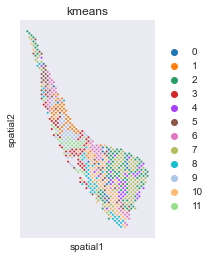

In [12]:
a = w1.copy()
# process gene expression
a = (a.T/a.sum(axis=1)).T
a = a + 1
a = np.log(a)
kmeans = KMeans(n_clusters=12, random_state=5).fit(a)
l1 = kmeans.labels_
layer1.obs['kmeans'] = [str(x) for x in l1]
sc.pl.spatial(layer1, color = 'kmeans', spot_size= 1)

... storing 'kmeans' as categorical


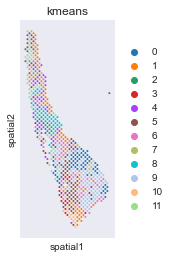

In [13]:
a = w2.copy()
# process gene expression
a = (a.T/a.sum(axis=1)).T
a = a + 1
a = np.log(a)
kmeans = KMeans(n_clusters=12, random_state=5).fit(a)
l2 = kmeans.labels_
layer2.obs['kmeans'] = [str(x) for x in l2]
sc.pl.spatial(layer2, color = 'kmeans', spot_size= 1)

Next, compare to center layer

... storing 'kmeans' as categorical


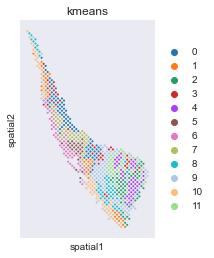

In [14]:
# We stored this value previously, which is why we are reading it in.
w_path = "../data/SCC/cached-results/patient4_W.npy"
w = np.load(w_path)

a = w.copy()
# process gene expression
a = (a.T/a.sum(axis=1)).T
a = a + 1
a = np.log(a)

kmeans = KMeans(n_clusters=12, random_state=8).fit(a)
l = kmeans.labels_
# inertias.append(kmeans.inertia_) 

# has same spatial coordinates as layer 1
center_layer = layer1.copy()
center_layer.obs['kmeans'] = [str(x) for x in l]
sc.pl.spatial(center_layer, color = 'kmeans', spot_size= 1)

## Calculate spatial coherence score

In [15]:
import networkx as nx
from scipy.spatial import distance_matrix
import random

def create_graph(adata, degree = 4):
        """
        Converts spatial coordinates into graph using networkx library.
        
        param: adata - ST Slice 
        param: degree - number of edges per vertex

        return: 1) G - networkx graph
                2) node_dict - dictionary mapping nodes to spots
        """
        D = distance_matrix(adata.obsm['spatial'], adata.obsm['spatial'])
        # Get column indexes of the degree+1 lowest values per row
        idx = np.argsort(D, 1)[:, 0:degree+1]
        # Remove first column since it results in self loops
        idx = idx[:, 1:]

        G = nx.Graph()
        for r in range(len(idx)):
            for c in idx[r]:
                G.add_edge(r, c)

        node_dict = dict(zip(range(adata.shape[0]), adata.obs.index))
        return G, node_dict
    
def generate_graph_from_labels(adata, labels_dict):
    """
    Creates and returns the graph and dictionary {node: cluster_label} for specified layer
    """
    
    g, node_to_spot = create_graph(adata)
    spot_to_cluster = labels_dict

    # remove any nodes that are not mapped to a cluster
    removed_nodes = []
    for node in node_to_spot.keys():
        if (node_to_spot[node] not in spot_to_cluster.keys()):
            removed_nodes.append(node)

    for node in removed_nodes:
        del node_to_spot[node]
        g.remove_node(node)
        
    labels = dict(zip(g.nodes(), [spot_to_cluster[node_to_spot[node]] for node in g.nodes()]))
    return g, labels

def spatial_coherence_score(graph, labels):
    g, l = graph, labels
    true_entropy = spatial_entropy(g, l)
    entropies = []
    for i in range(1000):
        new_l = list(l.values())
        random.shuffle(new_l)
        labels = dict(zip(l.keys(), new_l))
        entropies.append(spatial_entropy(g, labels))
        
    return (true_entropy - np.mean(entropies))/np.std(entropies)

def spatial_entropy(g, labels):
    """
    Calculates spatial entropy of graph  
    """
    # construct contiguity matrix C which counts pairs of cluster edges
    cluster_names = np.unique(list(labels.values()))
    C = pd.DataFrame(0,index=cluster_names, columns=cluster_names)

    for e in g.edges():
        C[labels[e[0]]][labels[e[1]]] += 1

    # calculate entropy from C
    C_sum = C.values.sum()
    H = 0
    for i in range(len(cluster_names)):
        for j in range(i, len(cluster_names)):
            if (i == j):
                z = C[cluster_names[i]][cluster_names[j]]
            else:
                z = C[cluster_names[i]][cluster_names[j]] + C[cluster_names[j]][cluster_names[i]]
            if z != 0:
                H += -(z/C_sum)*math.log(z/C_sum)
    return H

In [16]:
# Layer 1
g, l = generate_graph_from_labels(layer1, layer1.obs['kmeans'])
spatial_coherence_score(g, l)

# Note that for our plots we take the absolute value.

-66.9886789260436

In [17]:
# Layer 2
g, l = generate_graph_from_labels(layer2, layer2.obs['kmeans'])
spatial_coherence_score(g, l)

# Note that for our plots we take the absolute value.

-36.438885567607954

In [18]:
# Layer 3
g, l = generate_graph_from_labels(center_layer, center_layer.obs['kmeans'])
spatial_coherence_score(g, l)

# Note that for our plots we take the absolute value.

-103.85003124079529

Text(0, 0.5, 'Spatial Coherence Score')

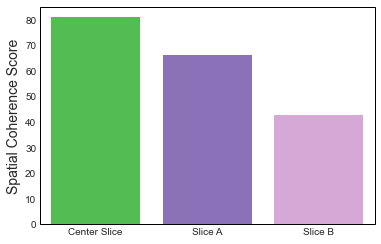

In [19]:
zscores = [-81.10,-66.18, -42.94, ]
zscores = np.abs(zscores)

colors = ["#41cf41", "#8766c4", "#dda0dd"]
labels = ['Center Slice', 'Slice A', 'Slice B']
ax2 = sns.barplot(x = labels, y = zscores, palette=sns.color_palette(colors))
ax2.set(ylabel="|Spatial Entropy Z-Score|")
ax2.set_facecolor('white')
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth('1')  
ax2.set_ylabel("Spatial Coherence Score", fontsize = 14)